---
title: "ЛАБОРАТОРНА РОБОТА 1"
subtitle: "з дисципліни «Обробка зображень методами штучного інтелекту»"
subtitle: "Варіант 11"
author: "Коваль Денис, студент групи ШІ-42"
institute: "Національний університет «Львівська політехніка»"
format:
  html: default
  pdf: default
  docx: default
lang: uk
---


### Load Images


У цьому розділі завантажуємо зображення з каталогу `images` та підготовлюємо їх для подальшої обробки. Використовуємо `matplotlib` для читання зображень у різних форматах (PNG, JPG, JPEG).


Також перетворюємо кольорові зображення (тільки половину з них - ті що у .png) у відтінки сірого, використовуючи стандартну формулу зважування каналів RGB. Для зображень з альфа-каналом (RGBA) спочатку видаляємо прозорість, залишаючи лише RGB канали.


In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


def read_image(path):
    return plt.imread(path)


img_dir = Path.cwd() / "images"
img_files = sorted(
    [
        os.path.join(img_dir, f)
        for f in os.listdir(img_dir)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]
)

images = []
for f in img_files:
    img = read_image(f)
    if img.dtype == np.float32 and img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    if f.lower().endswith(".png"): # Grayscale
        if img.ndim == 3:
            if img.shape[2] == 4:
                img = img[..., :3]
            img = np.dot(img[..., :3], [0.299, 0.587, 0.114])
    else: # RGB
        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)
        elif img.shape[2] == 4:
            img = img[..., :3]

    images.append(img)


### Gamma Reduction


Застосовуємо гама-корекцію для зменшення яскравості зображення. Гама-зменшення (з коефіцієнтом γ = 0.5) приглушує яскраві пікселі, роблячи зображення темнішим та зменшуючи контрастність.

**Математична формула гама-корекції:**

```
I_(x,y)(r,g,b) = 255 * ( (I_(x,y)(r,g,b)) / 255 )^(1/γ)
```

де 0 < γ < 1


In [2]:
def gamma_reduce(img, gamma=0.5):
    img = img.astype(np.float32)
    if img.ndim == 3:
        return np.clip(255.0 * np.power(img / 255.0, 1 / gamma), 0, 255).astype(
            np.uint8
        )
    return 255.0 * np.power(img / 255.0, 1 / gamma)


gamma_imgs = [gamma_reduce(img) for img in images]


### Display Results


Візуалізуємо результати обробки зображень, порівнюючи оригінальні зображення з результатами гама-зменшення.


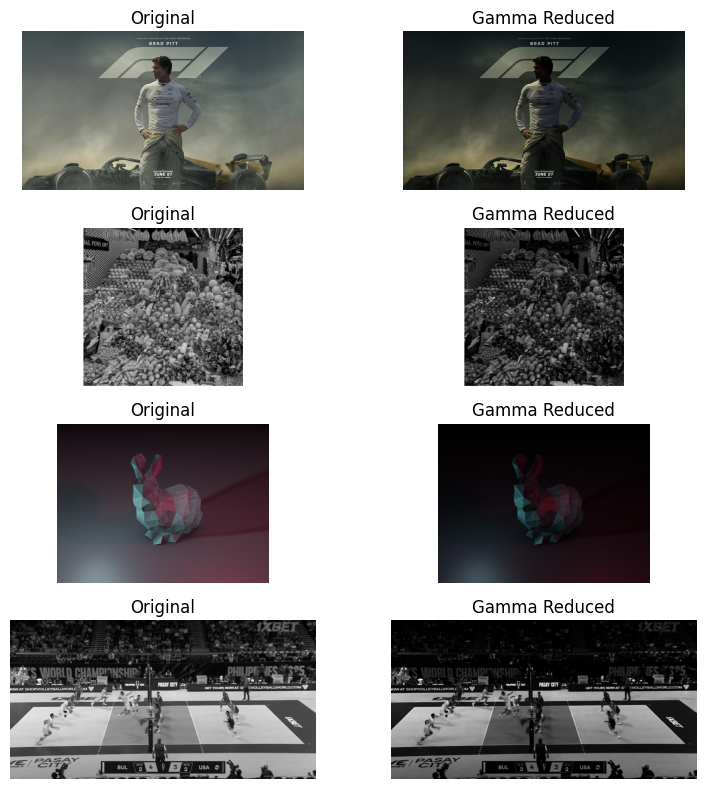

In [3]:
n = len(images)
fig, axs = plt.subplots(n, 2, figsize=(8, 2 * n))
if n == 1:
    axs = np.array([axs])
for i in range(n):
    if images[i].ndim == 3:
        axs[i, 0].imshow(images[i])
        axs[i, 1].imshow(gamma_imgs[i])
    else:
        axs[i, 0].imshow(images[i], cmap="gray")
        axs[i, 1].imshow(gamma_imgs[i], cmap="gray")
    axs[i, 0].set_title("Original")
    axs[i, 0].axis("off")
    axs[i, 1].set_title("Gamma Reduced")
    axs[i, 1].axis("off")
plt.tight_layout()
plt.show()


### Additional task: **Opening**


Реалізуємо морфологічну операцію "відкриття" (opening), яка є комбінацією ерозії та дилатації. Ця операція ефективно видаляє дрібний шум та ізольовані пікселі, зберігаючи при цьому основні об'єкти та їх контури.


In [4]:
def erode(img, kernel):
    if img.ndim == 3:
        result = np.zeros_like(img)
        for c in range(3):
            result[..., c] = erode(img[..., c], kernel)
        return result

    h, w = img.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode="edge")
    out = np.zeros_like(img)
    for i in range(h):
        for j in range(w):
            region = padded[i : i + kh, j : j + kw]
            out[i, j] = np.min(region[kernel])
    return out


def dilate(img, kernel):
    if img.ndim == 3:
        result = np.zeros_like(img)
        for c in range(3):
            result[..., c] = dilate(img[..., c], kernel)
        return result

    h, w = img.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode="edge")
    out = np.zeros_like(img)
    for i in range(h):
        for j in range(w):
            region = padded[i : i + kh, j : j + kw]
            out[i, j] = np.max(region[kernel])
    return out


def opening(img, kernel):
    return dilate(erode(img, kernel), kernel)


kernel = np.ones((7, 7), dtype=bool)
opened_imgs = [opening(img, kernel) for img in images]


### Display Opening Results


Порівнюємо результати морфологічної обробки з оригінальними зображеннями. Операція відкриття повинна показати очищення зображень від шуму при збереженні основних структурних елементів.


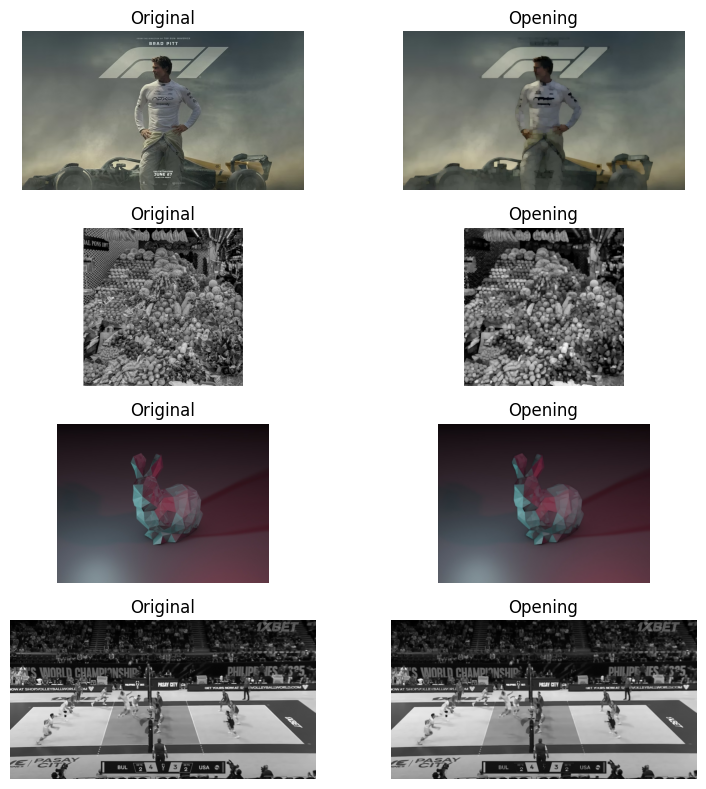

In [5]:
fig, axs = plt.subplots(n, 2, figsize=(8, 2 * n))
if n == 1:
    axs = np.array([axs])
for i in range(n):
    if images[i].ndim == 3:
        axs[i, 0].imshow(images[i])
        axs[i, 1].imshow(opened_imgs[i])
    else:
        axs[i, 0].imshow(images[i], cmap="gray")
        axs[i, 1].imshow(opened_imgs[i], cmap="gray")
    axs[i, 0].set_title("Original")
    axs[i, 0].axis("off")
    axs[i, 1].set_title("Opening")
    axs[i, 1].axis("off")
plt.tight_layout()
plt.show()


### Висновки

- Реалізовано перетворення у відтінки сірого та гама-зменшення без використання бібліотек обробки зображень.
- Додано морфологічну операцію відкриття (erode → dilate).
- Отримані результати відповідають очікуванню: гама-зменшення приглушує яскравість, відкриття прибирає дрібний шум зберігаючи контури.
